# Data wrangling and modelling for the product ingredients

_________________________________________________________________________________

**Reference file:**
- combined_data.json

__________________________________________________________________________________

## 1.0 Loading file

In [1]:
#Import necessary libraries
import json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
with open('../data/processed_data/combined_data.json', 'r') as file:
    data= json.load(file)
df=pd.DataFrame.from_dict(data)

In [3]:
df.head().T

,0,1,2,3,4
brand,Glow Recipe,Tatcha,goop,CLINIQUE,Tata Harper
product_name,Glow Recipe Watermelon Glow PHA +BHA Pore-Tigh...,Tatcha Pure One Step Camellia Oil Cleanser,goop GOOPGLOW Microderm Instant Glow Exfoliator,CLINIQUE Take The Day Off Makeup Remover For L...,Tata Harper Regenerating Exfoliating Cleanser
product_type,toners,face wash and cleansers,exfoliators and peels,face wash and cleansers,face wash and cleansers
num_likes,125100,107600,12900,76700,31000
rating,4.5,4.5,4.5,4.5,4.5
num_reviews,1900,1700,1200,3100,567
sensitive_type,0,1,0,0,0
combination_type,1,1,1,0,1
oily_type,1,1,1,0,0
normal_type,1,1,1,0,0


_________________________

## 2.0 Data wrangling and pre-processing

### *Approach 1: Using Fuzzymatch*

In [4]:
df_new=df.copy()

### 2.1 Clean data

In [5]:
#Import necessary libraries
#!pip install textsearch
#!pip install contractions
from nltk.tokenize import sent_tokenize
import re
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AffinityPropagation

In [6]:
def clean_ingr(text):
    '''
    text pre-processing for ingredients list
    '''
    text = str(text)
    text= unicodedata.normalize("NFKD", text)
    text= re.sub(r'[/\()-]',' ', text)
    text= re.sub(r'[^a-zA-Z\s,]', '', text)
    text= re.sub(r'\s*([,])\s*', ', ',text)
    text= text.lower().replace('\n','').replace('  ', ' ')
    
    new_text= re.split(', ', str(text))
    
    new_text= [i.strip() for i in new_text if i!='']
    
    #return list
    return new_text

In [7]:
df_new['ingr_list']=df_new['ingr_list'].apply(lambda x: clean_ingr(x))

In [8]:
df_new['ingr_list']

0       [opuntia ficus indica cactus extract, citrullu...
1       [cetyl ethylhexanoate, oryza sativa rice bran ...
2       [aqua, alumina, glycerin, cetearyl alcohol, gl...
3       [water, isohexadecane, dimethicone, cyclopenta...
4       [hordeum vulgare leaf juice, cetearyl alcohol,...
                              ...                        
1333    [rosa canina rosehip fruit oil, helianthus ann...
1334    [water aqua eau, butylene glycol, dimethicone,...
1335    [water, butylene glycol, glycerin, caprylic ca...
1336    [badaptive superfoodstm microcapsule complex, ...
1337    [aqua water, butylene glycol, glycerin, propan...
Name: ingr_list, Length: 1338, dtype: object

### 2.2 Simplify ingredients list using Fuzzywuzzy

In [9]:
#! pip install fuzzywuzzy
#! pip install python-Levenshtein

In [10]:
import fuzzywuzzy
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
from itertools import chain

In [11]:
#Create complete list of unique ingredients
ingr = list(df_new['ingr_list'])
ingr_list = list(set(chain(*ingr)))

In [12]:
print(f'{len(ingr_list)} unique ingredients before fuzzy match')

5963 unique ingredients before fuzzy match


**1. Calculating similarities**

Used fuzzy token sort ratio but other metrics can also be used (i.e. Levin)

In [13]:
ingr_df = pd.DataFrame(ingr_list)
ingr_df.columns = ['ingredients']


In [14]:
fuzz.token_sort_ratio('aha glycolic acid', 'aha acid')

64

In [ ]:
ct= pd.crosstab(ingr_df['ingredients'], ingr_df['ingredients'])
ct= ct.apply(lambda col: [fuzz.token_sort_ratio(col.name, x) for x in col.index])

In [ ]:
#Fuzz ratio taking so long! 
ct.head()

**2. Replace 100s since this is a comparison to itself**

In [ ]:
ct[ct==100]=0

**3. Create a dictionary to be used later for replacing values**

In [ ]:
def create_mapping(df, threshold=83):
    '''
    
    '''
    replaced=[]
    mapping={}
    for i in df:
        #returns col 
        col =df[i]
        cur_ingr = col.name
        close_strings= list(col[col>threshold].index)

        #check if ingr has already been replaced, if so, then check dictionary for ultimate word 
        #print(cur_ingr, )
        #print(close_strings)
        if cur_ingr in replaced:
            #print('Ingredient already replaced')
            for value in close_strings:
                mapping[value] = mapping[cur_ingr]
                replaced.append(value)
        else:
            #print('Replacing ', close_strings, ' with ', cur_ingr)
            for value in close_strings:
                mapping[value]=cur_ingr
                replaced.append(value)
        #print('\n')       
    #print('Full list of values replaced: \n', replaced)
    #print(f'{len(mapping)} ingredients to be mapped')
    return mapping

In [ ]:
mapping = create_mapping(ct, 83)

In [ ]:
mapping.head()

In [ ]:
mapped_df= pd.DataFrame.from_dict(mapping, orient='index')

In [ ]:
mapped_df.reset_index(inplace=True)
mapped_df.columns=['old', 'new']

In [ ]:
mapped_df

**4. Replaced values in the ingredients list**

In [ ]:
def replace_ingr(alist, dict_map):
    '''
    Takes in a list and replaces each value in the list according to the dictionary
    Returns comma separated doc/string
    '''
    for i in range(len(alist)):
        if alist[i] in dict_map.keys():
            alist[i] = dict_map[alist[i]]
    
    new_text = ", ".join(alist)
    return new_text

In [ ]:
df_new['ingr_list']= df_new['ingr_list'].apply(lambda x: replace_ingr(x, mapping))
df_new['ingr_list']

In [ ]:
ingr2 = list(df_new['ingr_list'].apply(lambda x: x.split(',')))
ingr_list2 = list(set(chain(*ingr2)))

In [ ]:
print(f'{len(ingr_list2)} unique ingredients after fuzzy match')

## 3.0 Modelling

In [ ]:
#Import necessary libraries
#!pip install textsearch
#!pip install contractions
from nltk.tokenize import sent_tokenize
import re
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#Defined custom tokenizer
def separate_ingr(text):
    '''
    Custom tokenizer: Returns a list of ingredients by partitioning text based on commas 
    '''
    new_text= re.split(', ', str(text))
    new_text= [i.strip() for i in new_text if i!=''] 
    #recreate the document from filtered tokens
    return new_text

In [ ]:
ingr_list = list(df_new.ingr_list)

**1. Count Vectorizer**

In [ ]:
cv= CountVectorizer(ingr_list, tokenizer= separate_ingr)
sparse_matrix= cv.fit_transform(ingr_list)
#print(cv.get_feature_names())

In [ ]:
listed_ingr=cv.get_feature_names
listed_ingr

In [ ]:
ingr_term_matrix = sparse_matrix.todense()
ingr_df = pd.DataFrame(ingr_term_matrix, columns= cv.get_feature_names())

In [ ]:
ingr_df.shape

**2. TF-IDF Features**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(ingr_list, tokenizer= separate_ingr)
tfidf_matrix= tf.fit_transform(ingr_list)
tfidf_matrix.shape

**3. Compute pairwise similarity using cosine**

In [ ]:
cos_sim_df = pd.DataFrame(cosine_similarity(tfidf_matrix))
cos_sim_df.head()

In [ ]:
#Similarity of product to one another
cos_sim_df.shape

**Adding product name for easy reference**

In [ ]:
df_new.reset_index(drop=True, inplace=True)

In [ ]:
product_sim_matrix = df_new[['product_name', 'product_type']].join(cos_sim_df.copy())

In [ ]:
#Create a mapping associating product name to index
index_product = dict(zip(df_new.index, df_new['product_name']))
#index_product

In [ ]:
index_product['product_type']='product_type'
index_product['product_name']='product_name'

In [ ]:
#Rename column names
product_sim_matrix.columns = product_sim_matrix.columns.map(index_product)
product_sim_matrix.rename(columns = {np.nan:'product_name'}, inplace = True)
product_sim_matrix.head()

In [ ]:
#Change index to match the original 
product_sim_matrix.index =df.index
product_sim_matrix.index

## 4. Exploring the results 

I have created custom functions for the me/the user to facilitate this.

A point to note in interpreting the results is that the similarity score is based on what is presumed to be the more 'active' ingredients.

#### What are the most similar products to X in terms of similarity?

In [120]:
def closest_products(prod, num=5, match_type=False):
    '''
    INPUT:
    prod - name of the product to find closest products for
    num - number of products to return 
    match_type - whether to return only products of similar type (i.e. toner, facial cleanser, etc.); true to consider product type, false otherwise
    
    OUTPUT: 
    Returns x num of products that are most similar to the item, including the similarity score
    '''
    results = product_sim_matrix[['product_name',prod]].sort_values(by=prod, ascending=False).head(num+1)
    
    if match_type==True:
        ptype = product_sim_matrix[product_sim_matrix.product_name==prod]['product_type'][0]
        results = product_sim_matrix.loc[product_sim_matrix.product_type==ptype, ['product_name', prod]].sort_values(by=prod, ascending=False).head(num+1)
    return results

In [121]:
closest_products('Shiseido WASO: Soft & Cushy Polishing Exfoliator',5, True)

,product_name,Shiseido WASO: Soft & Cushy Polishing Exfoliator
26,Shiseido WASO: Soft & Cushy Polishing Exfoliator,1.000000
351,philosophy Renewed Hope in a Jar Peeling Face ...,0.160439
42,LANCER Skincare The Method: Polish Oily-Conges...,0.155253
506,Peter Thomas Roth FIRMx™ Exfoliating Peel Gel,0.115985
400,Murad Intensive-C® Radiance Peel,0.113344
670,philosophy The Microdelivery Triple-Acid Brigh...,0.106906


In [46]:
for i in df.product_name.sample(5):
    print(i)

Kiehl's Since 1851 Eye Fuel
Kiehl's Since 1851 Ultra Facial Moisturizer
Sulwhasoo Bloomstay Vitalizing Serum
Mario Badescu Anti Acne Serum
The INKEY List 15% Vitamin C and EGF Brightening Serum


In [124]:
closest_products('SK-II SKINPOWER Essence Serum',5, True)

,product_name,SK-II SKINPOWER Essence Serum
456,SK-II SKINPOWER Essence Serum,1.000000
963,SK-II SKINPOWER Airy Milky Lotion,0.723126
628,SK-II GenOptics Aura Essence Serum,0.356878
681,Jack Black Line Smoother Oil-Free Moisturizer,0.218318
676,LANCER Skincare Retexturizing Treatment Cream ...,0.203917
455,Kiehl's Since 1851 Hydro-Plumping Re-Texturizi...,0.192221


In [128]:
closest_products('Murad Acne Body Wash', 5, True)

,product_name,Murad Acne Body Wash
492,Murad Acne Body Wash,1.000000
467,Murad Acne Control Clarifying Cleanser,0.289928
419,Murad Acne Control Clarifying Cream Cleanser,0.198988
160,Shiseido Deep Cleansing Foam,0.172053
310,Murad Essential-C Cleanser,0.170975
144,Murad Renewing Cleansing Cream,0.170964


#### How similar is Product A to Product B?

In [49]:
def compare_ingr(prod1, prod2):
    '''
    Returns similarity between two products
    '''
    sim = product_sim_matrix.loc[product_sim_matrix.product_name==prod1, ['product_name', prod2]]
    return sim

In [50]:
compare_ingr('SK-II SKINPOWER Essence Serum', 'SK-II Ultimate Revival Eye Cream')

,product_name,SK-II Ultimate Revival Eye Cream
456,SK-II SKINPOWER Essence Serum,0.450473


### Analysis of product similarity according to ingredients

In [129]:
matrix = product_sim_matrix.copy()
products= list(product_sim_matrix.columns)
products.remove('product_name')

In [130]:
#force self comparisons into NaN
for i in products:
    matrix.loc[matrix['product_name']==i,[i]]=np.nan

In [131]:
summary= matrix.describe().T
summary.head(15)

,count,mean,std,min,25%,50%,75%,max
Glow Recipe Watermelon Glow PHA +BHA Pore-Tight Toner,1337.0,0.019076,0.023948,0.0,0.002295,0.012382,0.026581,0.261264
Tatcha Pure One Step Camellia Oil Cleanser,1337.0,0.031167,0.029643,0.0,0.012386,0.024688,0.042426,0.357201
goop GOOPGLOW Microderm Instant Glow Exfoliator,1337.0,0.034652,0.026793,0.0,0.013852,0.028894,0.051417,0.138340
"CLINIQUE Take The Day Off Makeup Remover For Lids, Lashes & Lips",1337.0,0.027976,0.046984,0.0,0.006360,0.019266,0.039028,1.000000
Tata Harper Regenerating Exfoliating Cleanser,1337.0,0.028059,0.039865,0.0,0.007256,0.020312,0.036293,0.456562
Glow Recipe Blueberry Bounce Gentle Cleanser,1337.0,0.022929,0.027219,0.0,0.004823,0.016301,0.031748,0.344662
Caudalie Vinopure Pore Purifying Gel Cleanser,1337.0,0.042448,0.036127,0.0,0.019118,0.037099,0.057490,0.583588
REN Clean Skincare Mini Ready Steady Glow Daily AHA Toner,1337.0,0.020936,0.035906,0.0,0.000000,0.014532,0.030816,1.000000
The INKEY List Salicylic Acid Acne + Pore Cleanser,1337.0,0.052665,0.044911,0.0,0.022718,0.043659,0.069627,0.465359
Proactiv Deep Cleansing Face Wash,1337.0,0.031783,0.036180,0.0,0.012338,0.023937,0.039809,0.488454


**Products with considerable similarity to other products**

In [133]:
threshold= 0.5

In [134]:
n_products=len(summary[summary['max']>threshold])
total = df.shape[0]

print(r'Out of {} products analyzed, there are {} products ({}%) for which we have found comparable competitors (based on a {}% similarity in the ingredients list).'.format(total, n_products, 
                                                                           round(n_products/total*100,2),
                                                                           round(threshold*100,2)))

Out of 1338 products analyzed, there are 400 products (29.9%) for which we have found comparable competitors (based on a 50.0% similarity in the ingredients list).


In [135]:
#Here are some names
summary.sort_values(by='max', ascending=False)[85:105]

,count,mean,std,min,25%,50%,75%,max
Charlotte Tilbury Charlotte's Magic Night Cream,1337.0,0.049737,0.042868,0.0,0.025673,0.042297,0.066343,0.891872
The INKEY List C-50 Blemish Night Treatment,1337.0,0.053149,0.065287,0.0,0.021668,0.039013,0.061993,0.879268
The INKEY List Ceramide Hydrating Night Treatment,1337.0,0.050625,0.063843,0.0,0.020388,0.036132,0.058930,0.879268
SK-II SKINPOWER Airy Milky Lotion,1337.0,0.059108,0.055486,0.0,0.022710,0.049919,0.083267,0.876324
SK-II SKINPOWER Eye Cream,1337.0,0.055981,0.052635,0.0,0.021977,0.047663,0.077999,0.876324
CLINIQUE Repairwear Laser Focus Night Line Smoothing Cream for Combination Oily to Oily Skin,1337.0,0.058643,0.060442,0.0,0.026395,0.046507,0.070387,0.860454
CLINIQUE Repairwear Laser Focus Night Line Smoothing Cream for Very Dry to Dry Combination Skin,1337.0,0.061562,0.061888,0.0,0.028893,0.049695,0.075432,0.860454
LANEIGE Cream Skin Toner & Moisturizer,1337.0,0.049365,0.045256,0.0,0.025326,0.041978,0.063510,0.860436
LANEIGE Cream Skin Mist,1337.0,0.042559,0.042220,0.0,0.019551,0.036556,0.055188,0.860436
Dr. Barbara Sturm Darker Skin Tones Face Cream Rich,1337.0,0.050650,0.042050,0.0,0.029201,0.044708,0.064788,0.858636


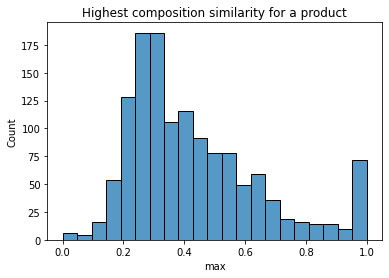

In [136]:
sns.histplot(summary['max'])
plt.title('Highest composition similarity for a product')
plt.show()

In [137]:
print(r'On average, the highest similarity achieved between one product to another is {}%'.format(round(summary['max'].mean()*100,2)))

On average, the highest similarity achieved between one product to another is 43.14%


<font color='red'> TBD - this should be relatively high I would think because this is based off TFIDF which already discounts the more common ingredients right? </font>

**By category**

Retrieve a list of the similar products by product type/ category

In [290]:
summary_toners = matrix[matrix.product_type=='toners'].describe().T
summary_cleansers = matrix[matrix.product_type=='face wash and cleansers'].describe().T
summary_serums = matrix[matrix.product_type=='essences, serums and treatments'].describe().T
summary_moisturizers = matrix[matrix.product_type=='moisturizers and creams'].describe().T
summary_peels = matrix[matrix.product_type=='exfoliators and peels'].describe().T
summary_eyes = matrix[matrix.product_type=='eye creams and treatments'].describe().T

In [325]:
def print_similar_prods(summarylist, threshold, num, match_type=True):
    '''
    print all the closest n products to the ones in the list 
    '''
    prod_list = summarylist[summarylist['max']>threshold].index.tolist()
    print(f'{len(prod_list)} products \n')
    for i in prod_list:
        print(i)
        for n in range(1,num+1):
            print(
                closest_products(i,num, match_type).values[n][0], ': ',
                 round(closest_products(i,num, True).values[n][1],2)
                )
        print('\n')

In [326]:
print_similar_prods(summary_cleansers, 0.4, 3, False)

152 products 

CLINIQUE Take The Day Off Makeup Remover For Lids, Lashes & Lips
CLINIQUE Take The Day Off Makeup Remover For Lids, Lashes & Lips Mini :  1.0
Bobbi Brown Instant Long-Wear Makeup Remover :  1.0
Lancôme Bi-Facil Face Bi-Phased Micellar Water Face Makeup Remover & Cleanser :  0.43


Proactiv Deep Cleansing Face Wash
Proactiv Deep Cleansing Wash :  0.49
Peter Thomas Roth Instant FIRMx® Temporary Face Tightener :  0.28
Clarins One-Step Gentle Exfoliating Cleanser with Orange Extract :  0.17


La Mer The Cleansing Gel
La Mer The Cleansing Foam :  0.61
La Mer The Tonic :  0.51
La Mer The Cleansing Oil :  0.5


innisfree Green Tea Hydrating Cleansing Oil
AMOREPACIFIC Vintage Single Extract Essence :  0.57
innisfree Green Tea Hydrating Cleansing Foam :  0.31
innisfree Green Tea Moisture-Balancing Emulsion :  0.25


ONE/SIZE by Patrick Starrr Mini GO OFF Makeup Dissolving Mist
ONE/SIZE by Patrick Starrr Mini GO OFF Makeup Dissolving Mist :  1.0
Algenist Advanced Anti-Aging Repair

IT Cosmetics Confidence in a Cleanser :  0.2


The Ordinary Glycolic Acid 7% Toning Solution
The Ordinary Amino Acids + B5 :  0.36
The Ordinary Natural Moisturizing Factors + HA :  0.2
The Ordinary Marine Hyaluronics :  0.19


Saturday Skin Pore Clarifying Toner 10% Glycolic Acid + Pore Control Complex
Saturday Skin Rise + Shine Gentle Cleanser :  0.23
Saturday Skin Rub-A-Dub Refining Peel Gel :  0.18
Saturday Skin Wide Awake Brightening Eye Cream with Avocado :  0.14


MILK MAKEUP Vegan Milk Cleanser
MILK MAKEUP Mini Vegan Milk Cleanser :  0.94
Origins Original Skin™ Cleansing Makeup Removing Jelly with Willowherb :  0.25
Volition Beauty Snow Mushroom Water Serum :  0.17


innisfree Green Tea Moisture-Balancing Toner
innisfree Green Tea Hydrating Sleeping Mask :  0.4
AMOREPACIFIC Vintage Single Extract Essence :  0.17
innisfree Green Tea Seed Intensive Hydrating Roll-On Eye Serum :  0.16


Bobbi Brown Instant Long-Wear Makeup Remover
CLINIQUE Take The Day Off Makeup Remover For Lids, 

The Ordinary Amino Acids + B5 :  0.46


JLo Beauty That JLo Glow Serum with Olive Complex
JLo Beauty That Blockbuster Wonder Cream with Hyaluronic Acid :  0.18
JLo Beauty That Hit Single Gel-Cream Cleanser :  0.15
JLo Beauty That Big Screen Moisturizer with Broad Spectrum SPF 30 :  0.13


The Ordinary Natural Moisturizing Factors + HA
The Ordinary "Buffet" :  0.62
The Ordinary Glycolic Acid 7% Toning Solution :  0.56
The Ordinary Amino Acids + B5 :  0.55


The Ordinary "Buffet"
The Ordinary "Buffet" + Copper Peptides 1% :  0.84
The Ordinary Natural Moisturizing Factors + HA :  0.62
The Ordinary Matrixyl* 10% + HA :  0.5


Dr. Jart+ Dermaclear™ Micro Milk Peel
Dr. Jart+ Dermaclear™ Micro Water :  0.18
Dr. Jart+ Dermaclear™ Micro Foam :  0.16
The Ordinary AHA 30% + BHA 2% Peeling Solution :  0.14


Dr. Zenovia Skincare Inflam-Aging Night Repair Treatment
Dr. Zenovia Skincare Advanced Retinol Night Repair Treatment :  0.5
Dr. Zenovia Skincare Aloe Vera Blemish Soothing Moisturizer :  0.4


belif Aqua Bomb Hydrating Toner :  0.34


Charlotte Tilbury Mini Magic Night 15ml Travel Size
Charlotte Tilbury Charlotte's Magic Night Cream :  0.89
Charlotte Tilbury Magic Eye Rescue Cream :  0.21
Charlotte Tilbury Multi-Miracle Glow Cleansing Balm :  0.17


REN Clean Skincare Clarimatte™ T-Zone Balancing Gel Cream
REN Clean Skincare Clarimatte™ T-Zone Cleansing Gel :  0.46
REN Clean Skincare ClearCalm Replenishing Gel Cream :  0.27
REN Clean Skincare Clearcalm Clarifying Clay Cleanser :  0.26


OTZI Hydro Crystal Lightweight Gel Moisturizer
OTZI Crystal Nova Gentle Makeup Removing Cleanser :  0.14
Drunk Elephant C-Tango™ Vitamin C Eye Cream :  0.13
AMOREPACIFIC TIME RESPONSE Skin Reserve Serum :  0.13


belif Pore Cleaner Moisturizer
belif Pore Cleaner Foam Cleanser :  0.44
belif Peat Miracle Revital Eye Cream :  0.33
belif Milky Hydra Balancing Moisturizer  :  0.31


Dior Capture Totale High-Performance Treatment Serum-Lotion
Dior Capture Totale Super Potent Age-Defying Intense Ser

In [327]:
print_similar_prods(summary_toners, 0.4, 3, False)

85 products 

Caudalie Vinopure Pore Purifying Gel Cleanser
Caudalie Vinopure Natural Salicylic Acid Pore Minimizing Toner :  0.25
Caudalie Vinopure Natural Oil Control Moisturizer :  0.17
Caudalie Vinopure Natural Salicylic Acid Pore Minimizing Serum :  0.16


REN Clean Skincare Mini Ready Steady Glow Daily AHA Toner
REN Clean Skincare Mini Ready Steady Glow Daily AHA Toner :  1.0
MILK MAKEUP Sunshine Oil :  0.09
REN Clean Skincare Glow Daily Vitamin C Gel Cream :  0.08


La Mer The Cleansing Gel
La Mer The Cleansing Foam :  0.61
La Mer The Tonic :  0.51
La Mer The Cleansing Oil :  0.5


innisfree Green Tea Hydrating Cleansing Oil
AMOREPACIFIC Vintage Single Extract Essence :  0.57
innisfree Green Tea Hydrating Cleansing Foam :  0.31
innisfree Green Tea Moisture-Balancing Emulsion :  0.25


Mario Badescu Enzyme Cleansing Gel
Mario Badescu Glycolic Acid Toner :  0.27
Mario Badescu Seaweed Night Cream :  0.22
Mario Badescu Anti Acne Serum :  0.2


belif Problem Solution Cleansing Foam
b

The Ordinary "Buffet" :  0.84
The Ordinary Natural Moisturizing Factors + HA :  0.55
The Ordinary Amino Acids + B5 :  0.46


GLAMGLOW SUPERMUD® Charcoal Instant Treatment Mask
GLAMGLOW SUPERTONER™ Exfoliating Acid Solution Toner :  0.37
GLAMGLOW SUPERSERUM™ 6-Acid Refining Treatment Serum :  0.23
GLAMGLOW SUPERCLEANSE™ Clearing Cream-to-Foam Cleanser :  0.23


The Ordinary Natural Moisturizing Factors + HA
The Ordinary "Buffet" :  0.62
The Ordinary Glycolic Acid 7% Toning Solution :  0.56
The Ordinary Amino Acids + B5 :  0.55


The Ordinary "Buffet"
The Ordinary "Buffet" + Copper Peptides 1% :  0.84
The Ordinary Natural Moisturizing Factors + HA :  0.62
The Ordinary Matrixyl* 10% + HA :  0.5


Dr. Zenovia Skincare Inflam-Aging Night Repair Treatment
Dr. Zenovia Skincare Advanced Retinol Night Repair Treatment :  0.5
Dr. Zenovia Skincare Aloe Vera Blemish Soothing Moisturizer :  0.4
Dr. Zenovia Skincare Bakuchiol Hydrating Cleanser :  0.19


The INKEY List Ceramide Hydrating Night Treat

In [328]:
print_similar_prods(summary_serums, 0.4, 3, False)

293 products 

Tata Harper Regenerating Exfoliating Cleanser
Tata Harper Restorative Anti-Aging Eye Cream :  0.32
Tata Harper Repairative Anti-Aging Moisturizer :  0.29
Tata Harper Resurfacing AHA + BHA Serum :  0.15


The INKEY List Salicylic Acid Acne + Pore Cleanser
The INKEY List Beta Hydroxy Acid (BHA) Blemish + Blackhead Serum :  0.39
Peter Thomas Roth Acne Clearing Wash :  0.34
Proactiv Deep Cleansing Wash :  0.3


La Mer The Cleansing Gel
La Mer The Cleansing Foam :  0.61
La Mer The Tonic :  0.51
La Mer The Cleansing Oil :  0.5


innisfree Green Tea Hydrating Cleansing Oil
AMOREPACIFIC Vintage Single Extract Essence :  0.57
innisfree Green Tea Hydrating Cleansing Foam :  0.31
innisfree Green Tea Moisture-Balancing Emulsion :  0.25


The INKEY List Polyhydroxy Acid (PHA) Gentle Exfoliating Toner
The Ordinary 100% Niacinamide Powder :  0.24
Mario Badescu Hyaluronic Dew Drops Hydrating Serum :  0.21
Summer Fridays Soft Reset AHA Exfoliating Solution :  0.18


Dr. Zenovia Skincare 

innisfree Cica Balm with Bija Seed Oil :  0.16


CLINIQUE Acne Solutions™ Clarifying Lotion
CLINIQUE Acne Solutions™ Clinical Clearing Gel :  0.21
CLINIQUE Acne Solutions™ Cleansing Foam :  0.18
CLINIQUE Acne Solutions™ Cleansing Gel :  0.16


SK-II Facial Treatment Cleanser
SK-II Facial Treatment Cleansing Oil :  0.24
Mario Badescu Glycolic Foaming Cleanser :  0.17
Mario Badescu Rose Hips Nourishing Oil :  0.17


Saturday Skin Rub-A-Dub Refining Peel Gel
Saturday Skin Pore Clarifying Toner 10% Glycolic Acid + Pore Control Complex :  0.11
Saturday Skin Rise + Shine Gentle Cleanser :  0.09
Saturday Skin Wide Awake Brightening Eye Cream with Avocado :  0.09


belif Aqua Bomb Jelly Cleanser
belif Aqua Bomb Mist :  0.41
belif Aqua Bomb Hydrating Toner :  0.39
belif Aqua Bomb Sleeping Mask :  0.31


Paula's Choice C15 Vitamin C Super Booster
Dr. Lara Devgan Scientific Beauty Vitamin C+B+E Ferulic Serum :  0.44
The Ordinary Alpha Arbutin 2% + HA :  0.21
The Ordinary Matrixyl* 10% + HA :  0.2

The Ordinary Lactic Acid 5% + HA :  0.36


CLINIQUE Even Better Clinical™ Radical Dark Spot Corrector + Interrupter Serum
CLINIQUE Clinique Smart™ Custom-Repair Serum :  0.62
CLINIQUE Clinique Smart™ Custom-Repair Eye Treatment :  0.32
CLINIQUE Even Better Skin Tone Correcting Lotion Broad Spectrum SPF 20 :  0.27


Tower 28 Beauty SOS Save.Our.Skin Daily Rescue Facial Spray
Tower 28 Beauty Mini SOS Save.Our.Skin Daily Rescue Facial Spray :  1.0
Lancôme Bi-Facil Face Bi-Phased Micellar Water Face Makeup Remover & Cleanser :  0.06
The Ordinary Argireline Solution 10% :  0.04


The Ordinary Resveratrol 3% + Ferulic Acid 3%
Dr. Lara Devgan Scientific Beauty Vitamin C+B+E Ferulic Serum :  0.42
Paula's Choice RESIST Weightless Advanced Repairing Toner :  0.3
Perricone MD Vitamin C Ester CCC+ Ferulic Brightening Complex 20% :  0.19


Lancôme Advanced Génifique Youth Activating Serum Duo
Lancôme Advanced Génifique Anti-Aging Face Serum :  1.0
Kiehl's Since 1851 Super Multi-Corrective Eye-Openi

Drunk Elephant Sweet Biome™ Fermented Sake Hydrating Spray :  0.55
The Ordinary Amino Acids + B5 :  0.53


The INKEY List Vitamin C Brightening Cream
The Ordinary Vitamin C Suspension 30% in Silicone :  0.95
The Ordinary 100% L-Ascorbic Acid Powder :  0.75
The Ordinary Ethylated Ascorbic Acid 15% Solution :  0.61


Charlotte Tilbury Charlotte's Magic Serum Crystal Elixir
Charlotte Tilbury Elixir Charlotte's Mini Magic Serum Crystal :  1.0
Peter Thomas Roth Peptide 21® Wrinkle Resist Serum :  0.2
Charlotte Tilbury Mini Lightweight Magic Cream Moisturizer SPF20 :  0.17


Dr. Dennis Gross Skincare Ferulic Acid + Retinol Brightening Solution
Dr. Dennis Gross Skincare Ferulic + Retinol Triple Correction Eye Serum :  0.55
Dr. Dennis Gross Skincare Clinical Grade IPL Dark Spot Correcting Serum :  0.3
Dr. Dennis Gross Skincare DRx Blemish Solutions™  Acne Eliminating Gel :  0.26


Dior Capture Totale Super Potent Age-Defying Intense Serum
Dior Capture Totale High-Performance Treatment Serum-Lo

Origins Plantscription™ Powerful Lifting Cream :  0.43
Origins PLANTSCRIPTION™ Multi-powered Anti-Aging Peptide Serum :  0.42


AMOREPACIFIC Vintage Single Extract Essence
innisfree Green Tea Hydrating Cleansing Foam :  0.48
innisfree Green Tea Hydrating Cleansing Oil :  0.29
innisfree Green Tea Moisture-Balancing Toner :  0.27


Caudalie Resveratrol Lift Lightweight Firming Cashmere Moisturizer
Caudalie Resveratrol Lift Instant Firming Serum :  0.24
Caudalie Resveratrol Lift Firming Eye Gel-Cream :  0.23
Caudalie Premier Cru Anti-Aging Cream :  0.17


Shiseido Future Solution LX Total Regenerating Cream
Shiseido Future Solution LX Eye and Lip Contour Regenerating Cream :  0.55
Shiseido Future Solution LX Concentrated Balancing Softener :  0.36
Shiseido Future Solution LX Intensive Firming Contour Serum :  0.36


Tata Harper Concentrated Brightening Essence
Tata Harper Concentrated Brightening Serum :  0.43
Tata Harper Boosted Contouring Serum :  0.37
Tata Harper Regenerating Exfoliati

La Mer The Moisturizing Matte Lotion :  0.52


SK-II SKINPOWER Airy Milky Lotion
SK-II SKINPOWER Eye Cream :  0.72
SK-II SKINPOWER Essence Serum :  0.31
SK-II Ultimate Revival Eye Cream :  0.23


IT Cosmetics Confidence in a Gel Lotion
Lord Jones Acid Mantle Repair Moisturizer With 250mg CBD and Ceramides :  0.58
Paula's Choice CLINICAL Ceramide-Enriched Firming Eye Cream :  0.44
Paula's Choice Omega+ Complex Serum :  0.36


Shiseido Treatment Softener Enriched
Shiseido Treatment Softener :  0.64
Shiseido Essential Energy Moisturizing Cream :  0.28
Shiseido Essential Energy Moisturizing Gel Cream :  0.2


Origins Plantscription™ Powerful Lifting Cream
Origins Plantscription™ SPF 25 Power Anti-Aging Cream :  0.56
Origins PLANTSCRIPTION™ Multi-powered Anti-Aging Peptide Serum :  0.54
Origins Plantscription™ SPF 25 Power Anti-Aging Oil-Free Cream :  0.46


Josie Maran Argan Moonstone Drops Makeup Priming and Highlighting Oil
Josie Maran 100 percent Pure Argan Oil Light  :  0.13
Wishful Ho

Dr. Zenovia Skincare Inflam-Aging Night Repair Treatment :  0.36
Dr. Zenovia Skincare Advanced Retinol Night Repair Treatment :  0.16


Josie Maran Skin Dope Argan + Hemp Oil
Josie Maran 100 percent Pure Argan Oil :  0.61
Josie Maran Pineapple Enzyme Pore Clearing Cleanser :  0.15
Josie Maran Skin Dope 100mg CBD Recovery Face Moisturizer :  0.08


Shiseido Essential Energy Moisturizing Gel Cream
Shiseido Essential Energy Moisturizing Cream :  1.0
Shiseido Essential Energy Day Cream SPF 20 :  0.66
Shiseido Treatment Softener Enriched :  0.46


LANEIGE Eye Sleeping Mask
LANEIGE Essential Power Skin Toner for Combination to Oily Skin :  0.28
LANEIGE Water Bank Dual Layer Face Oil :  0.17
LANEIGE Lavender Water Sleeping Mask :  0.14


REN Clean Skincare Keep Young And Beautiful™ Instant Brightening Beauty Shot Eye Lift
REN Clean Skincare Keep Young And Beautiful™ Instant Firming Beauty Shot :  0.14
Dr. Barbara Sturm Lifting Serum :  0.14
fresh Rose Deep Hydration Oil-Infused Serum :  0.11


Tata Harper Elixir Vitae Serum Wrinkle Solution :  0.36
Tata Harper Boosted Contouring Serum :  0.27
Tata Harper Concentrated Brightening Serum :  0.11


Estée Lauder Advanced Night Repair Eye Concentrate Matrix
Estée Lauder Advanced Night Repair Intense Reset Concentrate :  0.47
Estée Lauder Advanced Night Repair Eye Supercharged Complex :  0.26
CLINIQUE Dramatically Different Hydrating Jelly :  0.26


innisfree Green Tea Seed Intensive Hydrating Roll-On Eye Serum
innisfree Green Tea Seed Intensive Hydrating Cream :  0.55
innisfree Green Tea Seed Intensive Hydrating Eye Cream :  0.26
innisfree Green Tea Moisture-Balancing Toner :  0.25


Dior Capture Youth Age-Delay Advanced Eye Treatment
Dior Capture Youth Redness Soother Age-Delay Anti-Redness Soothing Serum :  0.36
Dior Capture Totale Firming & Wrinkle-Correcting Eye Cream :  0.35
Dior Capture Youth Age-Delay Advanced Crème :  0.32


fresh Crème Ancienne® Eye Cream
fresh Crème Ancienne® Infusion Toner :  0.38
fresh Crème Ancienne S

In [329]:
print_similar_prods(summary_eyes, 0.4, 3, True)

166 products 

Tata Harper Regenerating Exfoliating Cleanser
Tata Harper Clarifying Blemish & Oil Control Cleanser :  0.32
Tata Harper Nourishing Makeup Removing Oil Cleanser :  0.29
alpyn beauty PlantGenius® Creamy Bubbling Cleanser with Fruit Enzymes & AHAs :  0.15


La Mer The Cleansing Gel
La Mer The Cleansing Foam :  0.61
La Mer The Cleansing Oil :  0.51
La Mer The Cleansing Micellar Water :  0.5


Saturday Skin Rise + Shine Gentle Cleanser
innisfree Green Tea Hydrating Cleansing Foam :  0.17
Lancôme Crème Radiance Gentle Cleansing Creamy-Foam Cleanser :  0.15
innisfree Volcanic Clusters Pore Clearing Facial Foam :  0.15


LANEIGE Essential Power Skin Toner for Combination to Oily Skin
LANEIGE Essential Power Skin Toner for Normal to Dry Skin :  0.53
The INKEY List Polyhydroxy Acid (PHA) Gentle Exfoliating Toner :  0.14
The INKEY List Glycolic Acid Exfoliating Toner :  0.12


Naturally Serious Major Moisture Gentle Cream Cleanser
Peter Thomas Roth Water Drench® Cloud Cream Cleanse

Tata Harper Concentrated Brightening Serum :  0.66
Tata Harper Boosted Contouring Serum :  0.63
Tata Harper Rejuvenating Anti-Aging Serum :  0.33


Dr. Dennis Gross Skincare Ferulic Acid + Retinol Brightening Solution
Dr. Dennis Gross Skincare Clinical Grade IPL Dark Spot Correcting Serum :  0.55
Dr. Dennis Gross Skincare DRx Blemish Solutions™  Acne Eliminating Gel :  0.3
Dr. Dennis Gross Skincare Alpha Beta® Pore Perfecting & Refining Serum :  0.26


Dior Capture Totale Super Potent Age-Defying Intense Serum
Dior Capture Totale High-Performance Treatment Serum-Lotion :  0.7
Dior Capture Youth Matte Maximizer Age-Delay Mattifying Serum :  0.33
Dior Hydra Life Balancing Hydration 2 in 1 Sorbet Water :  0.27


Tata Harper Boosted Contouring Serum
Tata Harper Concentrated Brightening Serum :  0.71
Tata Harper Elixir Vitae Serum Wrinkle Solution :  0.63
Tata Harper Rejuvenating Anti-Aging Serum :  0.37


Dermalogica BioLumin-C Vitamin C Serum
Proactiv Blackhead Dissolving Gel :  0.21
The 

LANEIGE Water Bank Hydro Gel :  1.0
innisfree Tangerine Brightening & Pore-Refining Moisturizer :  0.25
innisfree Green Tea Seed Intensive Hydrating Cream :  0.22


Youth To The People Superfood Air-Whip Moisturizer with Hyaluronic Acid
L'Occitane Immortelle Precious Cream :  0.15
L'Occitane Shea Light Comforting Cream :  0.15
FENTY SKIN Hydra Vizor Invisible Moisturizer Broad Spectrum SPF 30 Sunscreen :  0.14


fresh Rose & Hyaluronic Acid Deep Hydration Moisturizer 
Caudalie Vinopure Natural Oil Control Moisturizer :  0.0
Dr. Barbara Sturm Brightening Face Lotion :  0.0
Moon Juice Cosmic Cream™ Collagen Protecting Moisturizer :  0.0


belif The True Cream Moisturizing Bomb
belif Milky Hydra Balancing Moisturizer  :  0.47
belif The True Cream Aqua Bomb :  0.37
belif Pore Cleaner Moisturizer :  0.33


Saturday Skin Pretty Pop Probiotic Power Whipped Cream
Saturday Skin Waterfall Glacier Water Cream :  0.55
CLINIQUE Moisture Surge™ Hydrating Lotion :  0.13
AMOREPACIFIC The Essential Cre

Sulwhasoo Essential Firming Cream :  0.31
Marc Jacobs Beauty Moisturizer Mini Youthquake Hydra-full Retexturizing Gel Crème :  0.26


CLINIQUE Clinique Smart Clinical™ MD Multi-Dimensional Age Transformer Duo Resculpt + Revolumize
CLINIQUE Clinique Smart Clinical™ MD Multi-Dimensional Age Transformer Revolumize :  0.97
CLINIQUE Smart Night™ Custom-Repair Moisturizer - Dry Combination :  0.47
CLINIQUE Smart Night Custom-Repair Moisturizer -Combination Oily to Oily :  0.42


Sulwhasoo Bloomstay Vitalizing Water
Sulwhasoo Bloomstay Vitalizing Serum :  0.77
Sulwhasoo Essential Balancing Water :  0.38
Sulwhasoo Concentrated Ginseng Renewing Serum :  0.36


Charlotte Tilbury Mini Magic Night 15ml Travel Size
Charlotte Tilbury Charlotte's Magic Night Cream :  0.89
CLINIQUE Dramatically Different Moisturizing Cream :  0.21
Charlotte Tilbury Magic Cream Moisturizer :  0.17


CLINIQUE Clinique Smart Clinical™ MD Multi-Dimensional Age Transformer Revolumize
CLINIQUE Clinique Smart Clinical™ MD Mu

CLINIQUE Repairwear™ Anti-Gravity Eye Cream :  0.44
CLINIQUE All About Eyes Serum De-Puffing Eye Massage :  0.43


Obagi Clinical Kinetin+ Hydrating Eye Cream
Obagi Clinical Vitamin C Eye Brightener :  0.41
Peter Thomas Roth Water Drench® Hyaluronic Cloud Hydrating Eye Gel :  0.24
Paula's Choice CLINICAL Ceramide-Enriched Firming Eye Cream :  0.22


Estée Lauder Advanced Night Repair Eye Concentrate Matrix
Estée Lauder Advanced Night Repair Eye Supercharged Complex :  0.47
CLINIQUE All About Eyes :  0.26
Estée Lauder Revitalizing Supreme Global Anti-Aging Eye Balm :  0.26


CLINIQUE Even Better Eyes Dark Circle Corrector
CLINIQUE All About Eyes :  0.69
CLINIQUE Repairwear™ Anti-Gravity Eye Cream :  0.37
CLINIQUE Clinique Smart™ Custom-Repair Eye Treatment :  0.31


innisfree Green Tea Seed Intensive Hydrating Roll-On Eye Serum
innisfree Green Tea Seed Intensive Hydrating Eye Cream :  0.55
AMOREPACIFIC Intensive Vitalizing Eye Essence :  0.26
AMOREPACIFIC TIME RESPONSE Eye Reserve Crème

In [330]:
print_similar_prods(summary_peels, 0.4, 3, True)

21 products 

Dr. Jart+ Dermaclear™ Micro Water
Dr. Jart+ Dermaclear™ Micro Foam :  0.28
LANEIGE Vitamin Brightening Cleansing Water :  0.16
Kate Somerville Gentle Daily Wash :  0.16


Saturday Skin Rise + Shine Gentle Cleanser
innisfree Green Tea Hydrating Cleansing Foam :  0.17
Lancôme Crème Radiance Gentle Cleansing Creamy-Foam Cleanser :  0.15
innisfree Volcanic Clusters Pore Clearing Facial Foam :  0.15


Dermalogica Daily Microfoliant Exfoliator
Dermalogica Daily Microfoliant Exfoliator :  1.0
Dermalogica Daily Superfoliant Exfoliator :  0.19
First Aid Beauty FAB Skin Lab Resurfacing Liquid 10% AHA :  0.11


Saturday Skin Pore Clarifying Toner 10% Glycolic Acid + Pore Control Complex
The INKEY List Glycolic Acid Exfoliating Toner :  0.23
Peter Thomas Roth 8% Glycolic Solutions Toner :  0.18
Peter Thomas Roth Water Drench® Hyaluronic Cloud Hydrating Toner Mist :  0.14


CLINIQUE City Block Purifying Charcoal Clay Mask + Scrub
CLINIQUE Acne Solutions™ Oil-Control Cleansing Mask :  

**Most common ingredients used**

In addition, this would also provide insight into the ingredients discounted in the similarity calculation.

In [331]:
ingr_mapping= cv.vocabulary_
ingr_dict = {v: k for k, v in ingr_mapping.items()}
ingr_count = pd.DataFrame.sparse.from_spmatrix(sparse_matrix)
ingr_count.columns= ingr_count.columns.map(ingr_dict)

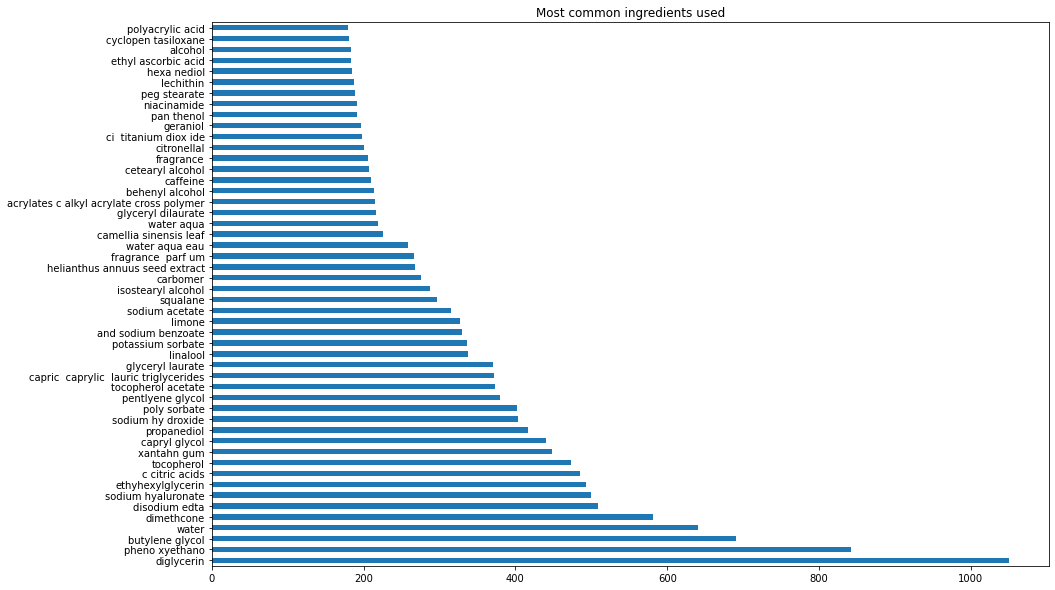

In [332]:
plt.figure(figsize=(15,10))
(ingr_count.sum().sort_values(ascending=False)[:50]).plot.barh()
plt.title('Most common ingredients used')
plt.show()

In [107]:
#Append product name to ingr_count for reference
ingr_count_df = df_new[['product_name']].join(ingr_count)

## 5.0 Saving dataframe

In [83]:
#Saving a copy of ingredients similarity with product name for reference
datapath_df = os.path.join('../data/processed_data', 'product_similarity.json')
if not os.path.exists(datapath_df):
    product_sim_matrix.to_json(datapath_df)

In [108]:
datapath_df = os.path.join('../data/processed_data', 'ingr_count.json')
if not os.path.exists(datapath_df):
    ingr_count_df.to_json(datapath_df)

________________________________________

In [ ]:
Conclusion and interpretation

# IGNORE BELOW

## 2.2 Approach 2: Cosine similarity, no fuzzymatching

Ingredients similarity without FuzzyMatching

In [ ]:
#Import necessary libraries
#!pip install textsearch
#!pip install contractions
from nltk.tokenize import sent_tokenize
import re
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#Defined custom tokenizer
def separate_ingr(text):
    '''
    Custom tokenizer: Returns a list of ingredients by partitioning text based on commas 
    '''
    #cleaning
    text = str(text)
    text= unicodedata.normalize("NFKD", text)
    text= re.sub(r'[/\()-]',' ', text)
    text= re.sub(r'[^a-zA-Z\s,]', '', text)
    text= re.sub(r'\s*([,])\s*', ', ',text)
    text= text.lower().replace('\n','').replace('  ', ' ')
    
    #tokenize document
    new_text= re.split(', ', str(text))
    
    new_text= [i.strip() for i in new_text if i!='']
    
    #recreate the document from filtered tokens
    return new_text

In [ ]:
ingr_list = list(df.ingr_list)

**Count Vectorizer**

In [ ]:
cv= CountVectorizer(ingr_list, tokenizer= separate_ingr)
sparse_matrix= cv.fit_transform(ingr_list)
listed_ingr=cv.get_feature_names

In [ ]:
ingr_term_matrix = sparse_matrix.todense()
ingr_df = pd.DataFrame(ingr_term_matrix, columns= cv.get_feature_names())

**TF-IDF Features**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(ingr_list, tokenizer= separate_ingr)
tfidf_matrix= tf.fit_transform(ingr_list)
tfidf_matrix.shape 

**Pairwise similarity using cosine**

In [ ]:
cos_sim_df = pd.DataFrame(cosine_similarity(tfidf_matrix))
cos_sim_df.head()

**Sample recommender**

In [ ]:
df.product_name.values

In [ ]:
def prod_recommender(product, products_list=df.product_name.values, doc_sims=cos_sim_df):
    # find product id
    prod_idx = np.where(products_list == product)[0][0]
    # get movie similarities
    product_similarities = doc_sims.iloc[prod_idx].values
    # get top 5 similar movie IDs
    similar_prod_idxs = np.argsort(-product_similarities)[1:6]
    # get top 5 movies
    similar_prod = products_list[similar_prod_idxs]
    # return the top 5 movies
    return similar_prod

In [ ]:
for i in df.product_name.values[23:34]:
    print('Recommendations for:', i)
    print('Top recommended:', prod_recommender(product=i, products_list = df.product_name.values, doc_sims = cos_sim_df))
    print('\n')

________________________________________

___________________

Methodologies
1) Fuzzy matching - We will use 'Levenshtein Similarity' for finding similarity score between two words.

2) Clustering - We will use 'Affinity Propagation Clustering' for grouping similar words against a standard form.


Note: Several other methods are available to perform fuzzy matching. Also, the standard form corresponding to a particular group of similar words (a cluster) is basically going to be the longest common substring across all the words in that cluster.

Steps:
    
1) Generate similarity matrix 
2) replace self comparisons with 0 
3) Apply a cut off to retain relevant similarities

In [ ]:
def fuzzy_match_replace(data, choices= ingr_list, score=fuzzywuzzy.fuzz.token_sort_ratio, min_ratio=83):
    '''
    
    '''
    #Get a list of unique strings
    for i in data:
        #Get closest matches
        matches = process.extract(string_to_match, chioces, limit=10, scorer = score)
        #Apply criteria
        close_matches = [matches[0] for matches in matches if matches[1]>=min_ratio]
        
        #Replace rows with close matches with the input match
    new_i = ''
    return new_i
    print('Done.')    

In [ ]:
mapping_ingr={}
for ingr in ingr_list[500:510]:
    tokenized = re.split(', ', ingr)
    for text in tokenized: 
        #Get closest matches
        matches = process.extract(text, ingr_list, limit=10, scorer = fuzzywuzzy.fuzz.token_sort_ratio)
        #Apply criteria
        close_matches = [matches[0] for matches in matches if matches[1]>=83]
        print(text, '------', close_matches)

https://www.kaggle.com/sushantpekar/string-similarity-fuzzy-matching-clustering

http://jonathansoma.com/lede/algorithms-2017/classes/fuzziness-matplotlib/fuzzing-matching-in-pandas-with-fuzzywuzzy/

https://stats.stackexchange.com/questions/123060/clustering-a-long-list-of-strings-words-into-similarity-groups

https://stackoverflow.com/questions/53261214/python-fuzzy-string-matching-as-correlation-style-table-matrix

_________________